In [18]:
import pandas as pd
import numpy as np

#Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-dark')

#DateTime
import datetime as dt

#Models
from sklearn.linear_model import LinearRegression
!pip install lightgbm
from lightgbm import LGBMRegressor

#Sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler

#Time to run Program
import time

In [21]:
def load_data():
  '''
  Function to Load the Train, Test and Submission Data

  returns: train, test, submission dataframes
  '''  
  train = pd.read_csv(r'file:///C:\Users\misso\Downloads\new_train%20(2).csv')
  test = pd.read_csv(r'file:///C:\Users\misso\Downloads\new_test%20(2).csv')
  submission = pd.read_csv(r'file:///C:\Users\misso\Downloads\sample_submission%20(1).csv')

  return train, test, submission


In [22]:
#Declare Traget and Feature
TARGET = 'temp'
feature = ['date']

In [23]:
train, test, submission = load_data()

In [24]:
train.head()

,date,temp
0,01-01-1980,4.16
1,02-01-1980,4.06
2,03-01-1980,7.12
3,04-01-1980,9.23
4,05-01-1980,3.20


In [25]:
test.head()

,date
0,01-01-2011
1,02-01-2011
2,03-01-2011
3,04-01-2011
4,05-01-2011


In [26]:
submission.head()

,prediction
0,5.57
1,5.57
2,5.57
3,5.57
4,5.57


In [27]:
#RMSE
def rmse():
  y_pred = train.iloc[10000:11322, 2]
  y = train.iloc[10000:11322, 0]
  metric = np.sqrt(mean_squared_error(y, y_pred))
  print(f"RMSE of Data is: {metric}")

#Hackathon Metric
def predict(model, model_features):
  pred_train = model.predict(X_train[model_features])
  pred_val = model.predict(X_val[model_features])

  print(f"Train RMSE = {np.sqrt(mean_squared_error(y_train, pred_train))}")
  print(f"Test RMSE = {np.sqrt(mean_squared_error(y_val, pred_val))}")

def run_gradient_boosting(clf, fit_params, train, test, features):
  N_SPLITS = 5
  oofs = np.zeros(len(train))
  preds = np.zeros((len(test)))

  target = train[TARGET]

  folds = StratifiedKFold(n_splits = N_SPLITS)
  stratified_target = pd.qcut(train[TARGET], 10, labels = False, duplicates='drop')

  feature_importances = pd.DataFrame()

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, stratified_target)):
    print(f'\n------------- Fold {fold_ + 1} -------------')

    ### Training Set
    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

    ### Validation Set
    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

    ### Test Set
    X_test = test[features]

    scaler = StandardScaler()
    _ = scaler.fit(X_trn)

    X_trn = scaler.transform(X_trn)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    _ = clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], **fit_params)

    fold_importance = pd.DataFrame({'fold': fold_ + 1, 'feature': features, 'importance': clf.feature_importances_})
    feature_importances = pd.concat([feature_importances, fold_importance], axis=0)

    ### Instead of directly predicting the classes we will obtain the probability of positive class.
    preds_val = clf.predict(X_val)
    preds_test = clf.predict(X_test)

    fold_score = metric(y_val, preds_val)
    print(f'\nRMSE score for validation set is {fold_score}')

    oofs[val_idx] = preds_val
    preds += preds_test / N_SPLITS


  oofs_score = metric(target, oofs)
  print(f'\n\nRMSE for oofs is {oofs_score}')

  feature_importances = feature_importances.reset_index(drop = True)
  fi = feature_importances.groupby('feature')['importance'].mean().sort_values(ascending = False)[:20][::-1]
  fi.plot(kind = 'barh', figsize=(12, 6))

  return oofs, preds, fi

def metric(y_true, y_pred):
  return np.sqrt(mean_squared_error(y_true, y_pred))

def download_preds(preds_test, file_name = 'hacklive_sub.csv'):

  ## 1. Setting the target column with our obtained predictions
  submission['prediction'] = preds_test

  ## 2. Saving our predictions to a csv file

  submission.to_csv(file_name, index = False)

  ## 3. Downloading and submitting the csv file
  from google.colab import files
  files.download(file_name)

#Download Submission File
def download(model, model_features, file_name = 'prophet.csv'):

  pred_test = model.predict(model_features)

  #Setting the target column with our obtained predictions
  submission['prediction'] = pred_test

  #Saving our predictions to a csv file
  submission.to_csv(file_name, index = False)
  
  #Downloadingthe csv file
  files.download(file_name)

def join_df(train, test):

  df = pd.concat([train, test], axis=0).reset_index(drop = True)
  features = [c for c in df.columns if c not in [feature, TARGET]]
  df[TARGET] = df[TARGET].apply(lambda x: np.log1p(x))

  return df, features

def split_df_and_get_features(df, train_nrows):

  train, test = df[:train_nrows].reset_index(drop = True), df[train_nrows:].reset_index(drop = True)
  features = [c for c in train.columns if c not in [feature, TARGET]]
  
  return train, test, features

In [28]:
#Combine Train and Test Dataframe
df, features = join_df(train, test)

In [29]:
df.head()

,date,temp
0,01-01-1980,1.640937
1,02-01-1980,1.621366
2,03-01-1980,2.094330
3,04-01-1980,2.325325
4,05-01-1980,1.435085


In [31]:
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")

train.shape: (11323, 2)
test.shape: (3561, 1)


In [32]:
train.describe()

,temp
count,11323.000000
mean,15.573259
std,7.877191
min,-5.110000
25%,8.390000
50%,15.990000
75%,22.055000
max,32.390000


In [33]:
#Check Datatypes
train.dtypes

date     object
temp    float64
dtype: object

In [34]:
print(f"Train Null Value Count: {train.isnull().sum()}")
print(f"Test Null Value Count: {test.isnull().sum()}")

Train Null Value Count: date    0
temp    0
dtype: int64
Test Null Value Count: date    0
dtype: int64


<AxesSubplot:title={'center':'Temperature Distribution'}, ylabel='Density'>

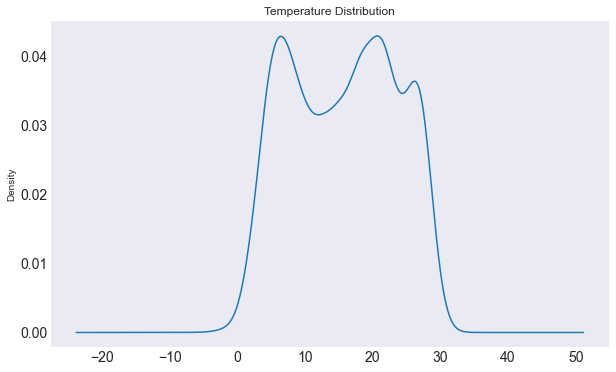

In [35]:
#Temperature Distribution
train[TARGET].plot(kind = 'density', title = 'Temperature Distribution', fontsize=14, figsize=(10, 6))

C:\Users\misso\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


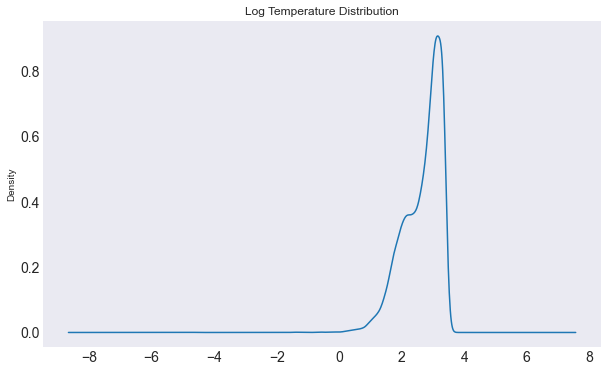

In [36]:
#Log Temperature Distribution
_ = pd.Series(np.log1p(train[TARGET])).plot(kind = 'density', title = 'Log Temperature Distribution', fontsize=14, figsize=(10, 6))

<AxesSubplot:title={'center':'Temperature Boxplot'}>

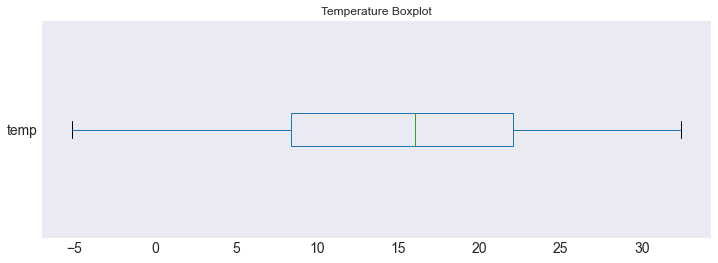

In [37]:
#Temperature Boxplot
train[TARGET].plot(kind = 'box', vert=False, figsize=(12, 4), title = 'Temperature Boxplot', fontsize=14)

C:\Users\misso\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:title={'center':'Log Temperature Boxplot'}>

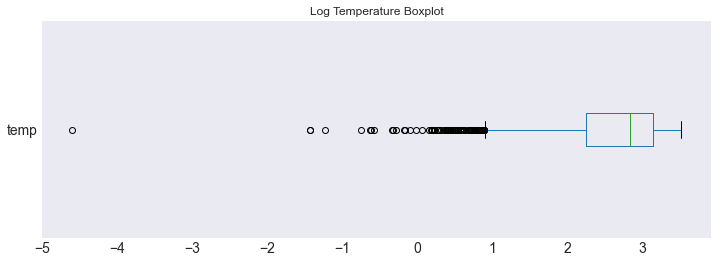

In [38]:
pd.Series(np.log1p(train[TARGET])).plot(kind = 'box', vert=False, figsize=(12, 4), title = 'Log Temperature Boxplot', fontsize=14)

In [39]:
#Convert `date` column datatype to `datetime`
df['date'] = pd.to_datetime(df['date'])

df.dtypes

date    datetime64[ns]
temp           float64
dtype: object

In [40]:
print(f"Train Null Value Count: {train.isnull().sum()}")
print(f"Test Null Value Count: {test.isnull().sum()}")

Train Null Value Count: date    0
temp    0
dtype: int64
Test Null Value Count: date    0
dtype: int64


In [41]:
#Make basic datetime features
# df['day_of_week'] = df['date'].dt.dayofweek
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['week'] = df['date'].dt.isocalendar().week  

#Get Train and Test sets from df
train, test, features = split_df_and_get_features(df, train.shape[0])

#Define the features
features = [c for c in df.columns if c not in [feature, TARGET]]
features = features[1:]
features

['year', 'month', 'week']

In [42]:
df.head()

,date,temp,year,month,week
0,1980-01-01,1.640937,1980,1,1
1,1980-02-01,1.621366,1980,2,5
2,1980-03-01,2.094330,1980,3,9
3,1980-04-01,2.325325,1980,4,14
4,1980-05-01,1.435085,1980,5,18


In [43]:
train.fillna(np.mean(train['temp']), inplace=True)

In [44]:
#Declare Features and Target from Training Dataset
X = train[features]
y = train[TARGET]

#Split Training and Validation Datasets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state = 42)

In [45]:
X.shape, y.shape

((11323, 3), (11323,))

In [46]:
#Linear Regression
model = LinearRegression()

model.fit(X_train[features], y_train)

predict(model, features)

Train RMSE = 0.5928992504796073
Test RMSE = 0.6142380849281177



------------- Fold 1 -------------


C:\Users\misso\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\misso\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[300]	valid_0's rmse: 0.659891

RMSE score for validation set is 0.4593860294790457

------------- Fold 2 -------------


C:\Users\misso\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\misso\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[300]	valid_0's rmse: 0.514348

RMSE score for validation set is 0.4964146541545341

------------- Fold 3 -------------


C:\Users\misso\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\misso\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[300]	valid_0's rmse: 0.435368

RMSE score for validation set is 0.41529388819174606

------------- Fold 4 -------------


C:\Users\misso\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\misso\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[300]	valid_0's rmse: 0.423333

RMSE score for validation set is 0.42294884500647706

------------- Fold 5 -------------


C:\Users\misso\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\misso\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[300]	valid_0's rmse: 0.391148

RMSE score for validation set is 0.39100139832931147


RMSE for oofs is 0.4385711414094438


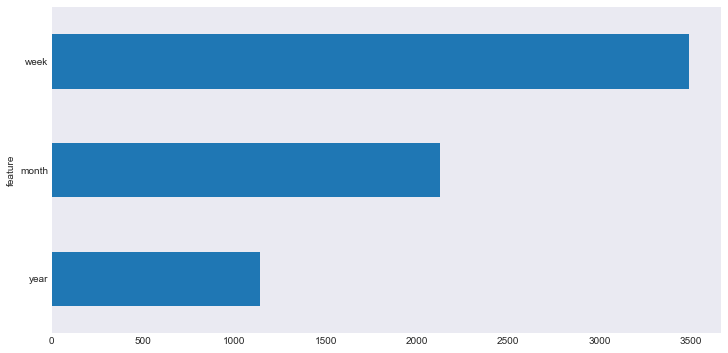

In [47]:
model = LGBMRegressor(n_estimators = 5000,
                        learning_rate = 0.01,
                        colsample_bytree = 0.76,
                        metric = 'None',
                        )
fit_params = {'verbose': 300, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf = model, fit_params = fit_params, train = train, test = test, features = features)

In [48]:
#Load Data
train, test, submission = load_data()

In [49]:
#Convert `date` column to datetime
train.date = pd.to_datetime(train.date)

In [50]:
#Set `date` as index
train.set_index('date', inplace = True)

In [51]:
train.head()

,temp
date,
1980-01-01,4.16
1980-02-01,4.06
1980-03-01,7.12
1980-04-01,9.23
1980-05-01,3.20


In [52]:
train.describe()

,temp
count,11323.000000
mean,15.573259
std,7.877191
min,-5.110000
25%,8.390000
50%,15.990000
75%,22.055000
max,32.390000


<AxesSubplot:xlabel='date'>

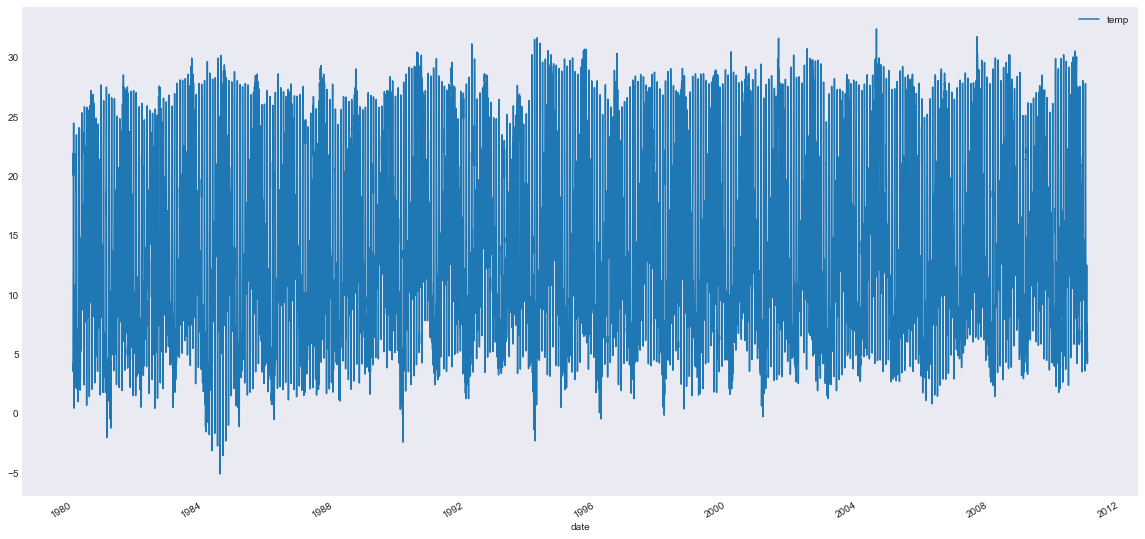

In [53]:
train.plot(figsize = (20, 10))

In [54]:
#Import adfuller test
from statsmodels.tsa.stattools import adfuller

In [55]:
# test_result = adfuller(train.temp)

In [56]:
#H0: It is not stationary
#H1: It is stationary

def adfuller_test(temp):
    result=adfuller(temp)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [57]:
adfuller_test(train.temp)

ADF Test Statistic : -10.24507580260353
p-value : 4.640501926156919e-18
#Lags Used : 40
Number of Observations Used : 11282
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


ADF Test Statistic : -8.151279157068243
p-value : 9.68101792578242e-13
#Lags Used : 40
Number of Observations Used : 11270
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<AxesSubplot:xlabel='date'>

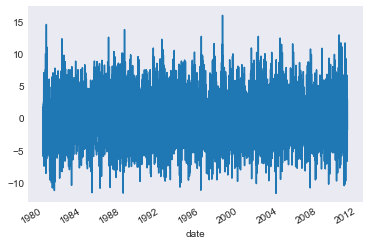

In [58]:
train['Seasonal First Difference']=train['temp']-train['temp'].shift(12) #Because 1 year has 12 months

## Again test dickey fuller test
adfuller_test(train['Seasonal First Difference'].dropna())

train['Seasonal First Difference'].plot()

In [59]:
from statsmodels.graphics.tsaplots import plot_pacf ,plot_acf

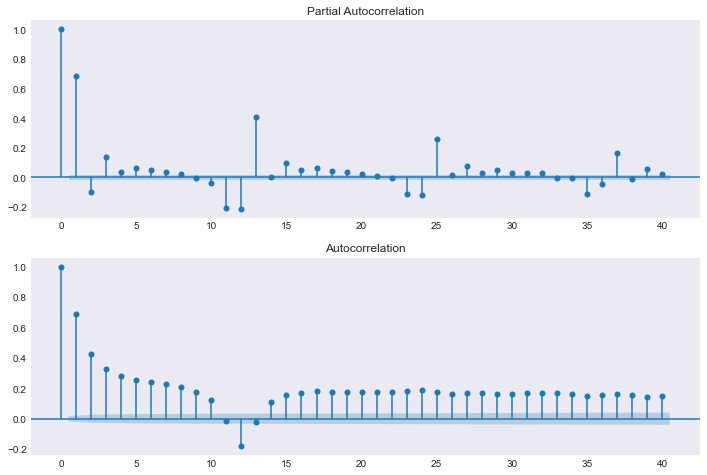

In [60]:
fig = plt.figure(figsize = (12, 8))
ax1 = fig.add_subplot(211)
fig = plot_pacf(train['Seasonal First Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_acf(train['Seasonal First Difference'].iloc[13:],lags=40,ax=ax2)

C:\Users\misso\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\misso\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

<AxesSubplot:xlabel='date'>

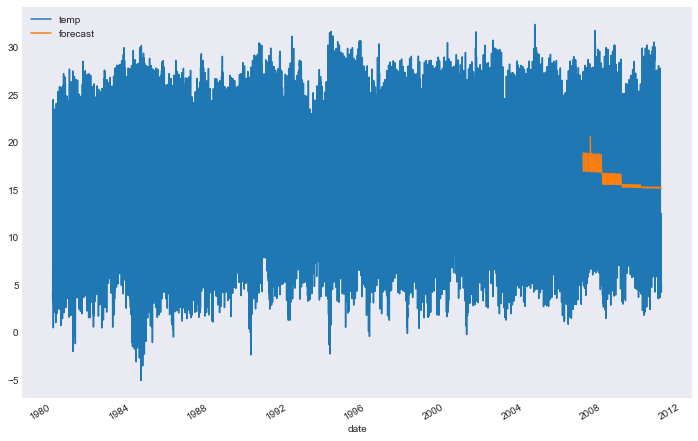

In [79]:
from statsmodels.tsa.arima_model import ARIMA

model=ARIMA(train['temp'],order=(2,0,2))
model_fit=model.fit()

model_fit.summary()

train['forecast']=model_fit.predict(start=10000,end=11321,dynamic=True)
train[['temp','forecast']].plot(figsize=(12,8))

In [80]:
import statsmodels.api as sm

C:\Users\misso\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\misso\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
C:\Users\misso\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\misso\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be i



Time of execution = 175.50323843955994
RMSE of Data is: 8.528238317389581


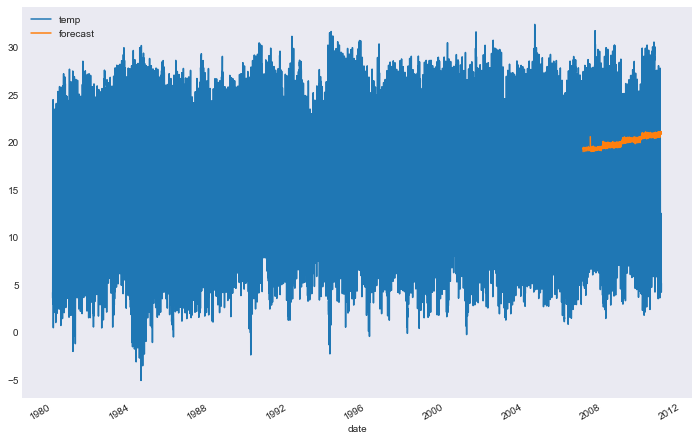

In [89]:
#Start time 
begin = time.time() 

model=sm.tsa.statespace.SARIMAX(train['temp'],order=(2, 1, 2),seasonal_order=(2, 1, 2, 12))
results=model.fit()

#End TIme
end = time.time()
print(f"\n\nTime of execution = {end - begin}")

#Forecast
train['forecast']=results.predict(start=10000,end=11321,dynamic=True)
train[['temp','forecast']].plot(figsize=(12,8))

rmse()

C:\Users\misso\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


<AxesSubplot:>

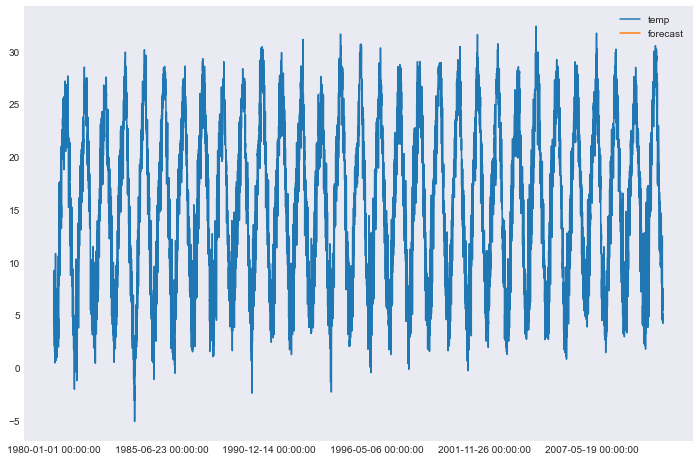

In [92]:
df = pd.concat([train, test])
df['forecast'] = results.predict(start = 11322, end = 14883, dynamic= True) 
df[['temp', 'forecast']].plot(figsize=(12, 8))

In [93]:
rmse()

RMSE of Data is: 8.528238317389581


In [95]:
def prophet_rmse(y_true, y_pred):

  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
import fbprophet
from fbprophet import Prophet

In [ ]:
#Load Data
train, test, submission = load_data()
train['date'] = pd.to_datetime(train['date'])

#Update column names
train.columns = ['ds', 'y']

In [ ]:
END_DATE = '2009'
X_train = train[train['ds'] <= END_DATE]
X_test = train[train['ds'] >= END_DATE]

In [ ]:
X_train.shape, X_test.shape

In [ ]:
#Add holidays to model

import holidays


holiday = pd.DataFrame([])
for date, name in sorted(holidays.UnitedStates(years=[2018,2019,2020]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "US-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [ ]:
# #Box Cox Transformation
# from scipy.stats import boxcox

# # Apply Box-Cox Transform to value column and assign to new column y
# train['y'] = train['y'] + 5.12 #Make Data Positive
# train['y'], lam = boxcox(train['y'])

In [ ]:
# train['y'].min()

In [ ]:
#Initialize model
model = Prophet(growth = 'linear', 
                  seasonality_mode = 'multiplicative',  
                  changepoint_prior_scale = 30,
                  seasonality_prior_scale = 15,
                  )

#Fit Model
model.fit(X_train)

prediction = model.predict(X_test[['ds']])
rmse = np.sqrt(mean_squared_error(X_test['y'], prediction['yhat']))
rmse

In [69]:
# from fbprophet.diagnostics import cross_validation
# cv_results = cross_validation(model, initial='730 days', period='180 days', horizon = '365 days')
# cv_results.head()

#Calculate RMSE
# prophet_rmse(cv_results.y, cv_results.yhat)

In [ ]:
#Alternate way to calculate rmse (without using cv)
prediction = model.predict(train[['ds']])
# model.plot(prediction);
# model.plot_components(prediction);

rmse = np.sqrt(mean_squared_error(train['y'], prediction['yhat']))
rmse

In [ ]:
def submit(model, file_name = 'prophet.csv'):

  #Load Test Data
  test = pd.read_csv('/content/drive/MyDrive/Data Science/dare2compete/DTU RoundHacks Data Science Hackathon/new_test.csv')

  #Convert `date` to datetime
  test['date'] = pd.to_datetime(test['date'])

  #Update column names
  test.columns = ['ds']

  #Make Predictions
  test_preds = model.predict(test)

  #Inverse Box Transform
  # from scipy.special import inv_boxcox

  #Apply inverse Box-Cox transform to specific forecast columns
  # test_preds[['yhat','yhat_upper','yhat_lower']] = test_preds[['yhat','yhat_upper','yhat_lower']].apply(lambda x: inv_boxcox(x, lam))

  #Inverse Data Addition
  # test_preds['yhat'] = test_preds['yhat'] - 5.12

  #Add prediction to submission file
  submission['prediction'] = test_preds['yhat']

  #Saving our predictions to a csv file
  submission.to_csv(file_name, index = False)
    
  #Downloadingthe csv file
  files.download(file_name)     #Works with Google Colab

In [ ]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [100,150,200]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

In [ ]:
import random

In [ ]:
strt='1980-01-01'
end='2009-01-01'

model_parameters = pd.DataFrame(columns = ['RMSE','Parameters'])
i = 0

for p in grid:
    test_tune = pd.DataFrame()
    print(f"Iteration: {i+1}/150")
    print(p)
    random.seed(0)

    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=holiday, 
                         interval_width=0.95)
    
    train_model.add_country_holidays(country_name='US')
    train_model.fit(X_train)

    # train_forecast = train_model.make_future_dataframe(periods=57, freq='D',include_history = False)
    # train_forecast = train[train['ds']>end]
    # train_forecast = train_model.predict(train_forecast[])

    train_forecast = train_model.predict(X_test)
    test_tune=train_forecast[['ds','yhat']]
    # Actual = train[(train['ds']>strt) & (train['ds']<=end)]
    Actual = X_test

    # print(Actual['y'].shape,test_tune['yhat'].shape)

    rmse = np.sqrt(mean_squared_error(Actual['y'],test_tune['yhat']))
    print('RMSE------------------------------------',rmse)
    model_parameters = model_parameters.append({'RMSE':rmse,'Parameters':p},ignore_index=True)
    print()

    i = i+1

    # break

In [ ]:
parameters = model_parameters.sort_values(by=['RMSE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

In [ ]:
parameters['Parameters'][0]

In [ ]:
# Setup and train model with holidays
final_model = Prophet(holidays=holiday,
                      changepoint_prior_scale= 0.1,
                      holidays_prior_scale = 0.1,
                      n_changepoints = 150,
                      seasonality_mode = 'multiplicative',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
final_model.add_country_holidays(country_name='US')
final_model.fit(X_train)

In [ ]:
tuned_pred.head()

In [ ]:
tuned_pred = final_model.predict(X_test)
prophet_rmse(tuned_pred['yhat'], X_test['y'])

In [ ]:
!pip install tbats

In [ ]:
train, test, submission = load_data()
train['date'] = pd.to_datetime(train['date'])

END_DATE = '2009'
X_train = train[train['date'] <= END_DATE]
X_test = train[train['date'] >= END_DATE]

In [ ]:
X_train.head()

In [ ]:
X_train.shape

In [ ]:
X_train.set_index('date', inplace = True)

In [ ]:
X_test.set_index('date', inplace = True)

In [ ]:
from tbats import TBATS, BATS

estimator = TBATS(seasonal_periods = (7, 365.25)  )
model = estimator.fit(X_train)